In [1]:
#MIN-MAX DATES
train_max_date = "2017-07-13"
train_min_date = "2015-07-13"
test_max_date = "2019-04-23"
test_min_date = "2017-04-23"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.window import Window as w
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

spark = (
    SparkSession.builder
    .config("spark.driver.memory","100g")
    .config("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider","com.amazonaws.auth.DefaultAWSCredentialsProviderChain")
    .config("spark.driver.maxResultSize",0)
    # .config('spark.hadoop.io.compression.codecs', 'nl.basjes.hadoop.io.compress.SplittableGzipCodec')
    .getOrCreate()
)
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.hadoop.io.compression.codecs", "org.apache.hadoop.io.compress.BZip2Codec")

s3_bucket_spark = "s3a://820323602090-team-dbad373c-7e36-407b-8690-05a44b804f43"
s3_bucket_pandas = "s3a://820323602090-team-dbad373c-7e36-407b-8690-05a44b804f43"
data_path = s3_bucket_spark + '/data/data_komodo/'

!aws s3 ls $team_bucket/data/data_komodo/

:: loading settings :: url = jar:file:/home/jovyan/.conda/envs/python3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9af75309-af9e-4541-80f5-4267eb90a09d;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 141ms :: artifacts dl 4ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------

                           PRE prm_diagnosis/
                           PRE prm_diagnosis_mk/
                           PRE prm_enrollment/
                           PRE prm_payers/
                           PRE prm_persons/
                           PRE prm_prescription/
                           PRE prm_prescription_1/
                           PRE prm_procedure/
                           PRE prm_providers/
                           PRE prm_visit/


## Get train and test NPI IDs

In [ ]:
path_to_targets = '../../instance_shared/life_sciences_hackathon-1/data/02_intermediate/'
train_target = spark.read.parquet(path_to_targets+'train_target.parquet').select('PROVIDER_NPI').withColumn('is_train', f.lit(1)).dropDuplicates()
test_target = spark.read.parquet(path_to_targets+'test_target.parquet').select('PROVIDER_NPI').withColumn('is_train', f.lit(0)).dropDuplicates()

## Load and filter data

In [ ]:
prm_diagn = spark.read.parquet(data_path+"prm_diagnosis/")\
                 .withColumn('npi_id', f.coalesce('npi_id', 'npi_id_2'))\
                 .withColumn('npi_id', f.coalesce('npi_id', 'npi_id_3'))\
                 .withColumn('PROVIDER_NPI', f.coalesce('npi_id', 'npi_id_4'))\
                 .withColumn('date_day', f.to_date(f.col('date_day'), 'yyyy-MM-dd'))\
                 .select('PROVIDER_NPI', 'date_day', 'person_id', 'vx_visit_id',
                         'primary_diagnosis_flag', 'dx_diagnosis_code', 'dx_diag_code_type')\
                 .filter(f.col('PROVIDER_NPI').isNotNull())\
                 .filter(f.col('date_day').isNotNull())\
                 .filter(f.col('person_id').isNotNull())\
                 .filter(f.col('vx_visit_id').isNotNull())\
                 .dropDuplicates()

In [ ]:
prm_diagn_train = prm_diagn.filter((f.col('date_day') < f.lit(train_max_date)) &
                                   (f.col('date_day') >= f.lit(train_min_date)))\
                           .join(train_target, on='PROVIDER_NPI', how='right')

prm_diagn_test = prm_diagn.filter((f.col('date_day') < f.lit(test_max_date)) &
                                  (f.col('date_day') >= f.lit(test_min_date)))\
                          .join(test_target, on='PROVIDER_NPI', how='right')

print('Train unique providers left:', prm_diagn_train.select('PROVIDER_NPI').distinct().count())
print('Test unique providers left:', prm_diagn_test.select('PROVIDER_NPI').distinct().count())

prm_diagn_clean = prm_diagn_train.union(prm_diagn_test)
prm_diagn_clean.write.parquet('../intermediate_data/diagnosis_with_persons.parquet', mode='overwrite')

## Make features

In [3]:
diagn = spark.read.parquet('../intermediate_data/diagnosis_with_persons.parquet')

diagn = diagn.withColumn('is_pso', f.when(((f.col('dx_diagnosis_code').startswith('L40')) &
                                           (f.col('dx_diag_code_type') != '9')) |
                                          ((f.col('dx_diagnosis_code').startswith('696')) &
                                           (f.col('dx_diag_code_type') != '10')), f.lit(1))
                                             .otherwise(f.lit(0)))

diagn = diagn.withColumn('last_3_months', f.when(((diagn.is_train == 1) &
                                                                      (f.months_between(f.lit(train_max_date),
                                                                                        f.col('date_day')) <= 3)) |
                                                                     ((diagn.is_train == 0) &
                                                                      (f.months_between(f.lit(test_max_date),
                                                                                        f.col('date_day')) <= 3)),
                                                                     1).otherwise(0))

diagn = diagn.withColumn('last_6_months', f.when(((diagn.is_train == 1) &
                                                  (f.months_between(f.lit(train_max_date),
                                                                    f.col('date_day')) <= 6)) |
                                                 ((diagn.is_train == 0) &
                                                  (f.months_between(f.lit(test_max_date),
                                                                    f.col('date_day')) <= 6)),
                                                 1).otherwise(0))\
             .drop('dx_diag_code_type', 'dx_diagnosis_code', 'date_day')

In [4]:
diagn.limit(5)

PROVIDER_NPI,person_id,vx_visit_id,primary_diagnosis_flag,is_train,is_pso,last_3_months,last_6_months
1023058567,e49097cdc475c2329...,938de33eb3c180359...,true,0,1,0,0
1023058567,ebf8b92605caa0bc9...,de1217c89ec4ee115...,false,0,0,0,0
1023058567,ebf8b92605caa0bc9...,4044fe6a0010c9b07...,false,0,0,0,0
1023058567,2b2b8f802e2951c17...,5430995a5372e1e14...,false,0,0,0,1
1023058567,8611956c384aee447...,5a87e6298f81f99b3...,true,0,0,0,0


In [5]:
diagn.write.parquet('../intermediate_data/diagnosis_with_persons_clean.parquet', mode='overwrite')

## Patients clustering

### From Diagnosis

In [7]:
diagn = spark.read.parquet('../intermediate_data/diagnosis_with_persons.parquet')
diagn.limit(5)

PROVIDER_NPI,date_day,person_id,vx_visit_id,primary_diagnosis_flag,dx_diagnosis_code,dx_diag_code_type,is_train
1023058567,2017-12-19,e49097cdc475c2329...,938de33eb3c180359...,true,L400,10,0
1023058567,2017-06-12,ebf8b92605caa0bc9...,de1217c89ec4ee115...,false,L814,10,0
1023058567,2017-12-15,ebf8b92605caa0bc9...,4044fe6a0010c9b07...,false,Z7189,10,0
1023058567,2018-12-10,2b2b8f802e2951c17...,5430995a5372e1e14...,false,Z09,10,0
1023058567,2017-10-28,8611956c384aee447...,5a87e6298f81f99b3...,true,Z7189,10,0


In [8]:
diagn = diagn.withColumn('is_pso', f.when(((f.col('dx_diagnosis_code').startswith('L40')) &
                                           (f.col('dx_diag_code_type') != '9')) |
                                          ((f.col('dx_diagnosis_code').startswith('696')) &
                                           (f.col('dx_diag_code_type') != '10')), f.lit(1))
                                             .otherwise(f.lit(0)))

diagn_pso_visits = diagn.filter(f.col('is_pso') == 1).groupBy(['person_id', 'is_train']).agg(
    f.countDistinct('vx_visit_id').alias('pso_visits_count')
)

diagn_visits = diagn.groupBy(['person_id','vx_visit_id','is_train']).agg(
    f.count('date_day').alias('encounters_count')
).groupBy(['person_id', 'is_train']).agg(
    f.avg('encounters_count').alias('avg_encounters_per_visit')
)

diagn = diagn.groupBy(['person_id', 'is_train']).agg(
    f.countDistinct('vx_visit_id').alias('visits_count'),
    f.countDistinct('PROVIDER_NPI').alias('nunique_providers'),
    f.max('is_pso').alias('had_pso')
)

diagn = diagn.join(diagn_visits, on=['person_id', 'is_train'], how='inner')\
             .join(diagn_pso_visits, on=['person_id', 'is_train'], how='left')
diagn = diagn.withColumn('pso_visits_share', f.col('pso_visits_count') / f.col('visits_count'))\
             .drop('pso_visits_count')

In [9]:
diagn.limit(5)

person_id,is_train,visits_count,nunique_providers,had_pso,avg_encounters_per_visit,pso_visits_share
0003824ed03b264bb...,0,1,1,1,1.0,1.0
00049c2d2f5bc6dc5...,1,1,1,1,3.0,1.0
00050ec91dba87e08...,1,1,1,1,2.0,1.0
00061c0453e346da3...,1,3,1,1,1.3333333333333333,1.0
0009ce8d8f78f5cd4...,1,1,1,1,3.0,1.0


In [10]:
diagn.write.parquet('../intermediate_data/persons_diag_fts.parquet', mode='overwrite')

### From procedures

In [5]:
proc = spark.read.parquet(data_path+"prm_diagnosis_mk/")\
                 .withColumnRenamed('primary_hcp_npi', 'PROVIDER_NPI')\
                 .withColumn('date_day', f.to_date(f.col('date_day'), 'yyyy-MM-dd'))\
                 .select('PROVIDER_NPI', 'date_day', 'vx_visit_id', 'person_id', 'dx_procedure_code')\
                 .filter(f.col('PROVIDER_NPI').isNotNull())\
                 .filter(f.col('date_day').isNotNull())\
                 .filter(f.col('vx_visit_id').isNotNull())\
                 .filter(f.col('person_id').isNotNull())\
                 .dropDuplicates()

prm_diagn_train = proc.filter((f.col('date_day') < f.lit(train_max_date)) &
                              (f.col('date_day') >= f.lit(train_min_date)))\
                      .join(train_target, on='PROVIDER_NPI', how='right')

prm_diagn_test = proc.filter((f.col('date_day') < f.lit(test_max_date)) &
                             (f.col('date_day') >= f.lit(test_min_date)))\
                     .join(test_target, on='PROVIDER_NPI', how='right')

proc = prm_diagn_train.union(prm_diagn_test)\
                      .select('vx_visit_id', 'person_id', 'dx_procedure_code', 'is_train').dropDuplicates()
proc.write.parquet('../intermediate_data/patients_with_proc.parquet', mode='overwrite')

In [6]:
proc = spark.read.parquet('../intermediate_data/patients_with_proc.parquet')
proc.limit(5)

vx_visit_id,person_id,dx_procedure_code,is_train
c6e8c3cc577982c6c...,eb0065f2b8bf0a115...,00W0X0Z,1
8343b77f9d5185642...,ca1bcefab55f50b74...,0BH17EZ,1
24a9df06bbc2efdf4...,e470c398356cc2ce1...,085N3ZZ,1
8343b77f9d5185642...,ca1bcefab55f50b74...,5A1945Z,1
423a2f8612add8500...,223bfcf73eaa46c92...,00W0X0Z,1


In [7]:
proc_visits = proc.groupBy(['vx_visit_id', 'person_id', 'is_train']).agg(
    f.countDistinct('dx_procedure_code').alias('nu_procedures')
).groupBy(['person_id', 'is_train']).agg(
    f.avg('nu_procedures').alias('nunique_procedures_per_visit')
)

proc = proc.groupBy(['person_id', 'is_train']).agg(
    f.countDistinct('dx_procedure_code').alias('nunique_procedures')
).join(proc_visits, on=['person_id', 'is_train']).na.fill(0)

proc.limit(5)

person_id,is_train,nunique_procedures,nunique_procedures_per_visit
278071d51e4deb7b5...,1,1,1.0
cd25b5103c2bd4286...,0,1,1.0
ac01ee8de47281bdd...,1,1,1.0
cc65b20d7291dc5db...,1,1,1.0
8d64371ce0ef136a1...,1,1,1.0


In [8]:
proc.write.parquet('../intermediate_data/persons_proc_fts.parquet', mode='overwrite')

### From enrollment

In [3]:
prm_enrol = spark.read.parquet(data_path+"prm_enrollment/").select('person_id', 'enr_plan_type').dropDuplicates()

23/04/26 09:05:13 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [5]:
prm_enrol = prm_enrol.withColumn('enr_plan_C', f.when(f.col('enr_plan_type') == 'C', 1).otherwise(0))\
                     .withColumn('enr_plan_S', f.when(f.col('enr_plan_type') == 'S', 1).otherwise(0))\
                     .withColumn('enr_plan_RR', f.when(f.col('enr_plan_type') == 'RR', 1).otherwise(0))\
                     .withColumn('enr_plan_M', f.when(f.col('enr_plan_type') == 'M', 1).otherwise(0))\
                     .withColumn('no_enr_plan', f.when(f.col('enr_plan_type').isNull(), 1).otherwise(0))

prm_enrol = prm_enrol.groupBy('person_id').agg(
    f.max('enr_plan_C').alias('enr_plan_C'),
    f.max('enr_plan_S').alias('enr_plan_S'),
    f.max('enr_plan_RR').alias('enr_plan_RR'),
    f.max('enr_plan_M').alias('enr_plan_M'),
    f.min('no_enr_plan').alias('no_enr_plan')
)

prm_enrol.limit(5)

person_id,enr_plan_C,enr_plan_S,enr_plan_RR,enr_plan_M,no_enr_plan
f67723418a2e75b87...,1,1,0,0,0
ee21f9d505746c8f5...,1,1,1,0,0
12a8ba76d395ac645...,0,0,1,0,0
5044ff0818a4bd3c9...,0,0,0,0,0
abad7dbd6a5d7fb79...,0,1,0,0,0


In [6]:
prm_enrol.write.parquet('../intermediate_data/persons_enrollments.parquet', mode='overwrite')

### From persons

In [18]:
prm_persons = spark.read.parquet(data_path+"prm_persons/")\
                        .withColumn('birth_year', f.when(f.col('px_birth_dt').isNull(), f.lit(None))
                                    .otherwise(f.col('px_birth_dt').substr(1,4)))\
                        .withColumn('is_female', f.when(f.col('px_gender') == 'F', 1).otherwise(0))\
                        .select('person_id','is_female','birth_year')\
                        .filter(f.col('person_id').isNotNull())\
                        .dropDuplicates()

prm_persons.limit(5)

23/04/26 09:54:34 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


person_id,is_female,birth_year
0025fe417c4cba661...,0,1953
00a20f1317dc2759e...,1,1988
00f3f2ad2dbfb1257...,0,1943
00fb2becd29e56ed4...,1,1977
01181d19d057fe59c...,0,1965


In [19]:
prm_persons.write.parquet('../intermediate_data/persons_socdem.parquet', mode='overwrite')

### From medicines

In [4]:
prescr = spark.read.parquet(data_path+"prm_prescription_1/")\
                   .withColumnRenamed('npi_id', 'PROVIDER_NPI')\
                   .withColumn('date_day', f.to_date(f.col('date_day'), 'yyyy-MM-dd'))\
                   .drop('rx_quantity', 'rx_drug_days_supply')\
                   .filter(f.col('PROVIDER_NPI').isNotNull())\
                   .filter(f.col('date_day').isNotNull())\
                   .filter(f.col('person_id').isNotNull())\
                   .dropDuplicates()

prescr_train = prescr.filter((f.col('date_day') < f.lit(train_max_date)) &
                             (f.col('date_day') >= f.lit(train_min_date)))\
                     .join(train_target, on='PROVIDER_NPI', how='right')

prescr_test = prescr.filter((f.col('date_day') < f.lit(test_max_date)) &
                            (f.col('date_day') >= f.lit(test_min_date)))\
                    .join(test_target, on='PROVIDER_NPI', how='right')

prescr = prescr_train.union(prescr_test)

prescr = prescr.withColumn('is_pso', f.when(((f.col('diagnosis').startswith('L40')) &
                                             (f.col('diagnosis_code_type') != '9')) |
                                            ((f.col('diagnosis').startswith('696')) &
                                             (f.col('diagnosis_code_type') != '10')), f.lit(1))
                           .otherwise(f.lit(0)))\
               .select('person_id', 'rx_ndc_code', 'is_pso', 'is_train')

prescr_all = prescr.groupBy(['person_id', 'is_train']).agg(f.countDistinct('rx_ndc_code').alias('nunique_ndc'))
prescr_pso = prescr.filter(f.col('is_pso') == 1).groupBy(['person_id', 'is_train']).agg(
    f.countDistinct('rx_ndc_code').alias('nunique_ndc_pso')
)
prescr = prescr_all.join(prescr_pso, on=['person_id', 'is_train'], how='left')
prescr.limit(5)

23/04/26 09:24:59 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


person_id,is_train,nunique_ndc,nunique_ndc_pso
176339930c729d727...,1,4,null
2fed8bdf92ca86efa...,1,0,null
59d4b7f1713dd5904...,1,0,null
cb559f497c1a1140d...,1,2,null
d7c7a6ff02df18608...,1,1,null


In [5]:
prescr.write.parquet('../intermediate_data/persons_medicines.parquet', mode='overwrite')

### From visits

In [9]:
prm_visit = spark.read.parquet(data_path+"prm_visit/").select('person_id', 'vx_visit_type')\
                 .filter(f.col('person_id').isNotNull()).dropDuplicates()

v_types = {
    'Non-hospital institution Visit':'nhiv',
    'Outpatient Visit':'opv',
    'Inpatient Visit':'iv',
    'Laboratory Visit':'lv',
    'Home Visit':'hv',
    'Ambulance Visit':'av',
    'Pharmacy Visit':'pv',
    'Emergency Room Visit':'erv'
}

for v_type in v_types:
    prm_visit = prm_visit.withColumn(f'visit_type_{v_types[v_type]}_share',
                                     f.when(f.col('vx_visit_type') == v_type, 1)
                                     .otherwise(0))
    
prm_visit = prm_visit.groupBy('person_id').agg(
    f.avg('visit_type_nhiv_share').alias('visit_type_nhiv_share'),
    f.avg('visit_type_opv_share').alias('visit_type_opv_share'),
    f.avg('visit_type_iv_share').alias('visit_type_iv_share'),
    f.avg('visit_type_lv_share').alias('visit_type_lv_share'),
    f.avg('visit_type_hv_share').alias('visit_type_hv_share'),
    f.avg('visit_type_av_share').alias('visit_type_av_share'),
    f.avg('visit_type_pv_share').alias('visit_type_pv_share'),
    f.avg('visit_type_erv_share').alias('visit_type_erv_share')
).na.fill(0)

prm_visit.limit(5)

person_id,visit_type_nhiv_share,visit_type_opv_share,visit_type_iv_share,visit_type_lv_share,visit_type_hv_share,visit_type_av_share,visit_type_pv_share,visit_type_erv_share
afa598bc8f70bb75e...,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.3333333333333333
48a429d6e9d727f82...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0
14574752d1c8969da...,0.0,0.3333333333333333,0.0,0.3333333333333333,0.0,0.0,0.0,0.0
dc128517c80cde0fc...,0.0,0.14285714285714285,0.14285714285714285,0.14285714285714285,0.14285714285714285,0.0,0.14285714285714285,0.14285714285714285
2dbe08c1e9830e50c...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
prm_visit.write.parquet('../intermediate_data/persons_visits.parquet', mode='overwrite')

### Merge and preprocess features

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

import joblib

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
files_folder = '../intermediate_data/'
fts_files = [f for f in os.listdir(files_folder) if f.startswith('persons_')]

trusted_file = 'persons_diag_fts.parquet'
fts_files = [trusted_file] + [f for f in fts_files if f != trusted_file]
fts_files

['persons_diag_fts.parquet',
 'persons_socdem.parquet',
 'persons_proc_fts.parquet',
 'persons_medicines.parquet',
 'persons_visits.parquet',
 'persons_enrollments.parquet']

In [20]:
persons = pd.read_parquet(files_folder + fts_files[0]).fillna(0)

for fts_file in fts_files[1:]:
    
    print(fts_file)
    
    temp_df = pd.read_parquet(files_folder + fts_file).fillna(0)
    
    if 'is_train' in temp_df.columns:
        persons = persons.merge(temp_df, how='outer')
    
    else:
        persons = persons.merge(temp_df, how='left')
        
persons.fillna(0, inplace=True)

persons_socdem.parquet
persons_proc_fts.parquet
persons_medicines.parquet
persons_visits.parquet
persons_enrollments.parquet


In [21]:
persons['birth_year'] = persons['birth_year'].astype(int)

In [36]:
def get_too_high_nan_shares(features_df, nan_share_threshold = .95):
    
    nan_shares = features_df.drop(['is_train', 'person_id'], axis=1).isnull().mean().reset_index()
    return nan_shares.loc[nan_shares[0] > nan_share_threshold, 'index'].values.tolist()

def get_high_correlated_features(features_df, correlation_threshold = .975):
    
    corr_matrix = features_df.drop(['is_train', 'person_id'], axis=1).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    
    return to_drop

def get_high_univariant_features(features_df, univariant_threshold = .99):
    
    univariant_list = []
    total_n = features_df.shape[0]
    
    for fts in [f for f in features_df.columns if f not in ['is_train', 'person_id']]:
        
        if persons[fts].value_counts().iloc[0] / total_n >= univariant_threshold:
            univariant_list.append(fts)
    
    return univariant_list

In [39]:
nan_fts = get_too_high_nan_shares(persons)
corr_fts = get_high_correlated_features(persons)
uv_fts = get_high_univariant_features(persons, univariant_threshold = .95)
persons.drop(list(set(nan_fts)|set(corr_fts)|set(uv_fts)), axis=1, inplace=True)

In [41]:
potential_outliers = [c for c in persons.columns if c.endswith('count')
                      or c.startswith('nunique') or c.startswith('avg')]
potential_outliers

['visits_count',
 'nunique_providers',
 'avg_encounters_per_visit',
 'nunique_ndc']

In [49]:
for po_col in potential_outliers:
    persons[po_col] = np.clip(persons[po_col], -np.inf, persons[po_col].quantile(.99))

In [57]:
scaler = StandardScaler().fit(persons.iloc[:,2:])
joblib.dump(scaler, '../models/persons_clustering_scaler.sav ')

['../models/persons_clustering_scaler.sav ']

In [59]:
persons_scaled = persons.drop(['person_id', 'is_train'], axis=1).copy()
persons_scaled.iloc[:,:] = scaler.transform(persons_scaled.iloc[:,:])

### Run and save clustering

In [66]:
inertias = []

for n_clusters in range(1,10):
    print(n_clusters, end='... ')
    kmeans = KMeans(n_clusters=n_clusters, random_state=3225).fit(persons_scaled.values)
    inertias.append(kmeans.inertia_)
    
print('done!')

1... 2... 3... 4... 5... 6... 7... 8... 9... done!


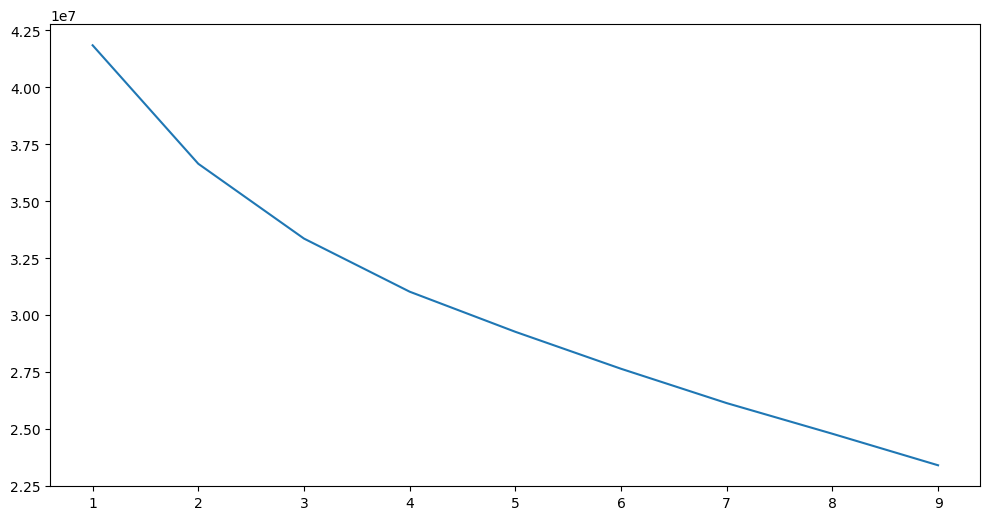

In [69]:
plt.figure(figsize=(12,6))
plt.plot(range(1,10), inertias)

In [70]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=3225).fit(persons_scaled.values)
clusters = kmeans.predict(persons_scaled.values)

In [72]:
pd.Series(clusters).value_counts()

1    878287
2    787253
0    460690
3    197955
dtype: int64

In [76]:
clust_result = persons[['person_id', 'is_train']]
clust_result['cluster'] = clusters
clust_result = pd.get_dummies(clust_result, columns=['cluster'], prefix='cluster')

In [78]:
clust_result['person_id'] = clust_result['person_id'].astype(str)
clust_result.to_parquet(files_folder + 'persons_clusters.parquet')

## Create persons features

### Merge with clusters

In [3]:
persons = spark.read.parquet('../intermediate_data/diagnosis_with_persons_clean.parquet')\
               .join(spark.read.parquet('../intermediate_data/persons_clusters.parquet')
                     .drop('__index_level_0__'), on=['person_id', 'is_train'], how='left')\
               .na.fill(0)

### Calculate features

**nunique clients**

In [4]:
persons_pso_prim = persons.filter((f.col('is_pso') == 1) &
                                  (f.col('primary_diagnosis_flag') == 'true'))\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso_primary')
)

persons_pso = persons.filter(f.col('is_pso') == 1)\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso')
)

persons_all = persons.groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients')
)

persons_pso_prim_l3m = persons.filter((f.col('is_pso') == 1) &
                                      (f.col('primary_diagnosis_flag') == 'true') & 
                                      (f.col('last_3_months') == 1))\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso_primary_l3m')
)

persons_pso_l3m = persons.filter((f.col('is_pso') == 1) &
                                 (f.col('last_3_months') == 1))\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso_l3m')
)

persons_all_l3m = persons.filter(f.col('last_3_months') == 1).groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_l3m')
)

persons_pso_prim_l6m = persons.filter((f.col('is_pso') == 1) &
                                      (f.col('primary_diagnosis_flag') == 'true') & 
                                      (f.col('last_6_months') == 1))\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso_primary_l6m')
)

persons_pso_l6m = persons.filter((f.col('is_pso') == 1) &
                                 (f.col('last_6_months') == 1))\
                          .groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_pso_l6m')
)

persons_all_l6m = persons.filter(f.col('last_6_months') == 1).groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.countDistinct('person_id').alias('nunique_clients_l6m')
)

for fts in [persons_pso_prim, persons_pso,
            persons_pso_prim_l3m, persons_pso_l3m, persons_all_l3m,
            persons_pso_prim_l6m, persons_pso_l6m, persons_all_l6m]:
    persons_all = persons_all.join(fts, on=['PROVIDER_NPI', 'is_train'], how='left').na.fill(0)

**visits by clusters**

In [5]:
visits = persons.groupBy(['PROVIDER_NPI', 'is_train', 'vx_visit_id']).agg(
    f.max('cluster_0').alias('cluster_0'),
    f.max('cluster_1').alias('cluster_1'),
    f.max('cluster_2').alias('cluster_2'),
    f.max('cluster_3').alias('cluster_3')
).groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.avg('cluster_0').alias('client_cluster_0_visits_share'),
    f.avg('cluster_1').alias('client_cluster_1_visits_share'),
    f.avg('cluster_2').alias('client_cluster_2_visits_share'),
    f.avg('cluster_3').alias('client_cluster_3_visits_share')
)

visits_l3m = persons.filter(f.col('last_3_months') == 1).groupBy(['PROVIDER_NPI', 'is_train', 'vx_visit_id']).agg(
    f.max('cluster_0').alias('cluster_0'),
    f.max('cluster_1').alias('cluster_1'),
    f.max('cluster_2').alias('cluster_2'),
    f.max('cluster_3').alias('cluster_3')
).groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.avg('cluster_0').alias('client_cluster_0_visits_share_l3m'),
    f.avg('cluster_1').alias('client_cluster_1_visits_share_l3m'),
    f.avg('cluster_2').alias('client_cluster_2_visits_share_l3m'),
    f.avg('cluster_3').alias('client_cluster_3_visits_share_l3m')
)

visits_l6m = persons.filter(f.col('last_6_months') == 1).groupBy(['PROVIDER_NPI', 'is_train', 'vx_visit_id']).agg(
    f.max('cluster_0').alias('cluster_0'),
    f.max('cluster_1').alias('cluster_1'),
    f.max('cluster_2').alias('cluster_2'),
    f.max('cluster_3').alias('cluster_3')
).groupBy(['PROVIDER_NPI', 'is_train']).agg(
    f.avg('cluster_0').alias('client_cluster_0_visits_share_l6m'),
    f.avg('cluster_1').alias('client_cluster_1_visits_share_l6m'),
    f.avg('cluster_2').alias('client_cluster_2_visits_share_l6m'),
    f.avg('cluster_3').alias('client_cluster_3_visits_share_l6m')
)

for fts in [visits, visits_l3m, visits_l6m]:
    persons_all = persons_all.join(fts, on=['PROVIDER_NPI', 'is_train'], how='left').na.fill(0)

**nunique by cluster**

In [6]:
for cluster in [0,1,2,3]:

    nu_clus = persons.filter(f.col(f'cluster_{cluster}') == 1).groupBy(['PROVIDER_NPI', 'is_train']).agg(
        f.countDistinct('person_id').alias(f'nunique_clients_cluster_{cluster}')
    )
    persons_all = persons_all.join(nu_clus, on=['PROVIDER_NPI', 'is_train'], how='left').na.fill(0)

In [7]:
dynamic_cols = [
    'nunique_clients_pso_primary',
    'nunique_clients_pso',
    'nunique_clients',
    'client_cluster_0_visits_share',
    'client_cluster_1_visits_share',
    'client_cluster_2_visits_share',
    'client_cluster_3_visits_share'
]

for dyn_col in dynamic_cols:
    persons_all = persons_all.withColumn(dyn_col + '_l3m_vs_l6m', f.when(f.col(dyn_col + '_l6m') == 0, 1)
                                         .otherwise(f.col(dyn_col + '_l3m') / f.col(dyn_col + '_l6m')))
    persons_all = persons_all.withColumn(dyn_col + '_l3m_vs_l2y', f.when(f.col(dyn_col) == 0, 1)
                                         .otherwise(f.col(dyn_col + '_l3m') / f.col(dyn_col)))

In [8]:
persons_all.na.fill(0).write.parquet(
    '../../instance_shared/life_sciences_hackathon-1/data/04_feature/persons_categories.parquet'
)

23/04/26 11:08:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Check features

In [1]:
import pandas as pd
fts = pd.read_parquet('../../instance_shared/life_sciences_hackathon-1/data/04_feature/persons_categories.parquet')
print(fts.shape)
print('null count total: ', fts.isnull().sum().sum())
fts.is_train.value_counts()

(26185, 41)
null count total:  0


0    13416
1    12769
Name: is_train, dtype: int64